# O Problema

O problema consiste em realizar análises em um ativo do mercado de ações utilizando a biblioteca do Yahoo Finance. 

- Objetivo: Extrair algum padrão para tentar prever uma tendência futura para os próximos 5 dias.

Nessa análise iremos utilizar uma rede neural recorrente (LSTM) para predizer os preços do próximos 5 dias do ativo PETR4. O desempenho da rede neural será comparado com um modelo estatístico clássico, utilizado aqui como baseline, conhecido como SARIMA. Além disso, outros dois estudos de predição serão realizados: o primeiro visa mostrar se o preço de abertura do ativo pode ser utilizado para predizer o preço de fechamento, do mesmo dia. E o segundo utililiza um algoritmo de Machiene Learning para predizer o preço de fechamento do ativo do dia seguinte.

# Bibliotecas Utilizadas

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as ts

from keras.layers import LSTM, Dense
from keras.models import Sequential, load_model

import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook
from pmdarima import auto_arima

import yfinance as yf
import datetime as dt
import matplotlib as mpl
from pylab import rcParams
rcParams['axes.labelsize']  = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['lines.linewidth'] = 3
rcParams['figure.figsize']  = 22,8

## Baixando os dados

O ativo selecionado para análise inicial é a Petrobrás S.A.(PETR4). Essa empresa foi selecionada dada sua importância no mercado brasileiro e internacional.

In [2]:
today = dt.date.today()
petr = yf.download("PETR4.SA", start="2017-01-01", end="{}".format(today))

[*********************100%***********************]  1 of 1 completed


# Análise Descritiva e Exploratória

O objetivo desta seção é conhecer melhor o comportamento dos preços da série temporal em estudo.

Abaixo é possível visualizar os últimos 5 dias de cotações da PETR4. Nas análises realizadas nesse estudo serão utilizados os preços de abertura e de fechamento ajustado. O preço de fechamento a ser utilizado será o "ajustado" pois neste os descontos de pagamentos de dividendos e juros sobre capital próprio já foram devidamente corrigidos.

In [3]:
print(petr.tail())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-07  27.270000  27.790001  26.670000  27.000000  27.000000  72664200
2020-12-08  26.809999  27.139999  26.459999  26.660000  26.660000  46276700
2020-12-09  26.629999  26.969999  26.400000  26.940001  26.940001  52448300
2020-12-10  27.190001  28.200001  27.129999  27.820000  27.820000  97537100
2020-12-11  27.490000  27.780001  27.280001  27.410000  27.410000  30843600


É sempre interessante iniciar uma análise de série temporal visualizando os dados. Abaixo é possível visualizar o preço de fechamento ajustado ao longo do tempo. Percebe-se uma tendência de baixo no início do ano 2017 até junho desse ano. Depois tem-se uma forte tendência de alta até maio de 2018, seguida por uma forte correção. No final de junho desse ano temos o início de uma tendência de alta que perdura, com alguma várias oscilações e correções até março de 2020, quando temos o evento causado pelo COVID-19, trazendo uma forte queda no preço do ativo. Porém, no mês seguinte inicia-se uma recuperação e os preços entram em forte tendência de alta no final da série.

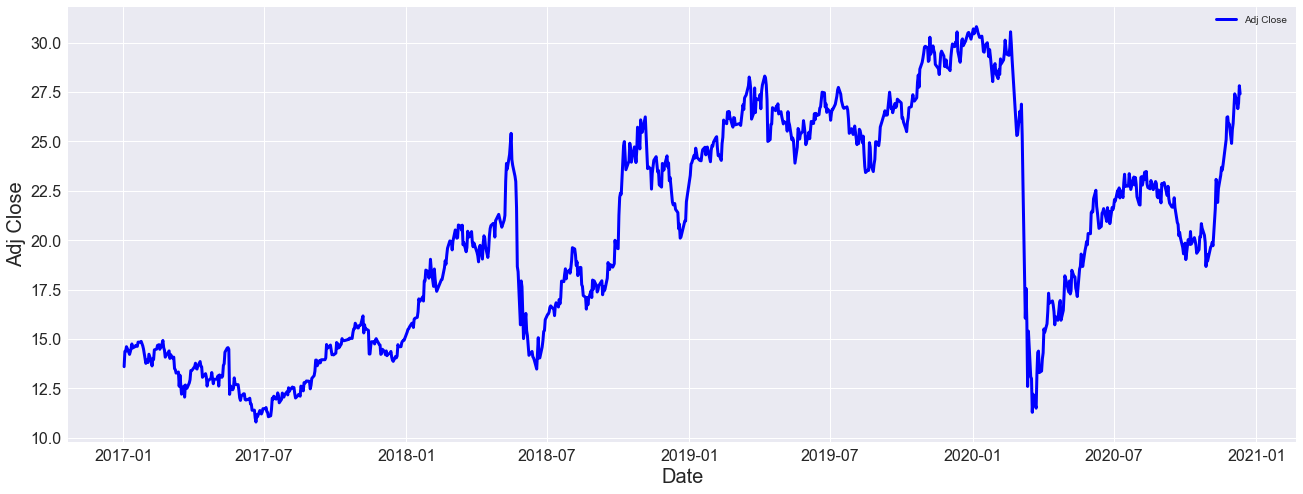

In [4]:
sns.lineplot(x='Date', y='Adj Close', data=petr, color='blue', label='Adj Close');

Abaixo é possível verificar que a série não possui "valores faltantes" (NaN's).

In [5]:
petr.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

A tabela abaixo mostra diversas propriedades estatísticas da série que permitem conhecê-la melhor. Por exemplo, a tabela mostra o preço médio, mínimo e máximo, entre outras características, de todas as variáveis da base de dados.

In [6]:
petr.describe()

,Open,High,Low,Close,Adj Close,Volume
count,982.000000,982.000000,982.000000,982.000000,982.000000,9.820000e+02
mean,21.194959,21.490489,20.868951,21.166181,20.355457,5.797144e+07
std,5.410796,5.443782,5.373369,5.412120,5.553598,3.207385e+07
min,11.070000,12.010000,10.850000,11.290000,10.798459,0.000000e+00
25%,15.982500,16.132499,15.727500,15.905000,14.861795,3.705770e+07
50%,21.280001,21.580000,21.010000,21.400000,20.201958,5.041325e+07
75%,26.242500,26.537501,25.809999,26.165000,25.327960,6.873338e+07
max,30.889999,31.240000,30.500000,30.969999,30.807720,2.548138e+08


É possível fazer um "resampling" da série temporal, o que permite visualizar com mais clareza as tendências e comportamento geral dos preços. Nos dois gráficos abaixo, os preço de fechamento ajustado foi redimensionado para períodos semanais e mensais, utilizando para isso a média dos preços nesses períodos. Com isso, é possível perceber uma suavização dos preços em relação à séries original, e os movimentos de alta e baixa, bem como os pico e fundos ficam mais evidentes.

In [7]:
close_resample_week = petr['Adj Close'].resample('W').mean()

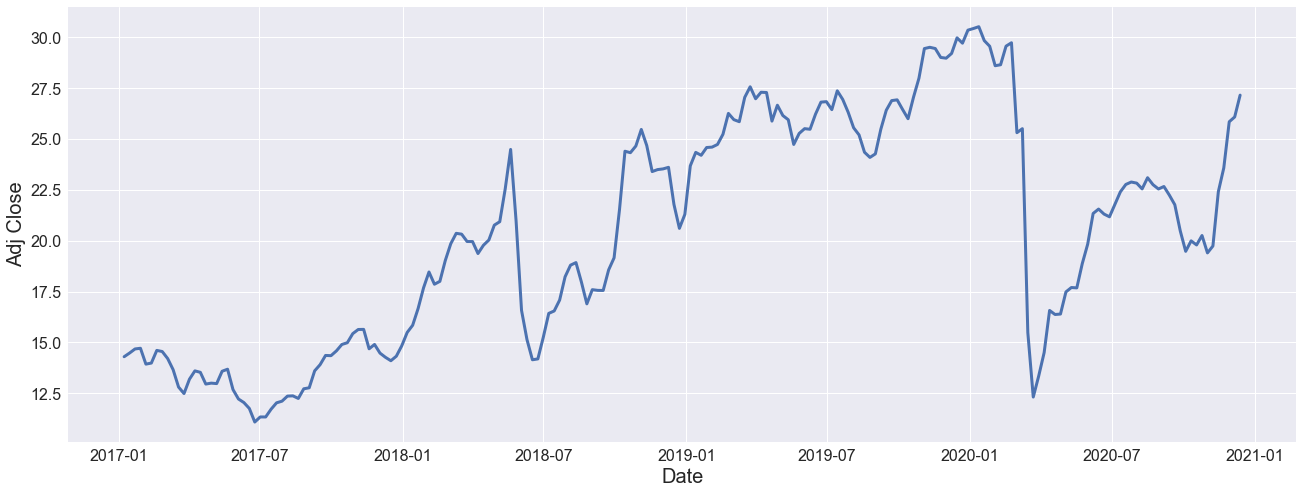

In [8]:
sns.lineplot(x=close_resample_week.index, y=close_resample_week);

In [9]:
close_resample_month = petr['Adj Close'].resample('M').mean()

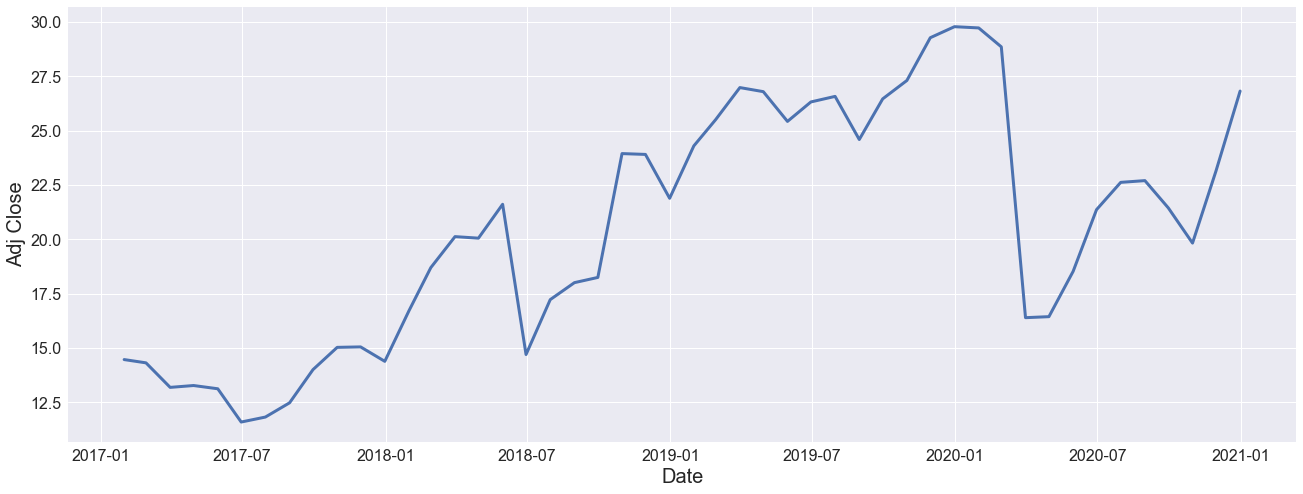

In [10]:
sns.lineplot(x=close_resample_month.index, y=close_resample_month);

Aqui, iremos gerar algumas variáveis novas que permitirão investigar mais a fundo alguns padrões e comportamento da série temporal. Essa variáveis mostram as cotações em períodos que não estão originalmente na base de dados, como o mês e dia da semana. Com isso, é possível realizar algumas análise que permitem entender melhor o comportamento dos preços.

In [11]:
petr['Month'] = petr.index.month
petr['Week Day'] = petr.index.dayofweek
petr['Day'] = petr.index.day
petr['Year'] = petr.index.year

É possível visualizar na tabela abaixo que agora temos outras duas variáveis em nossa base de dados: o mês (Month) e o dia da semana (Week Day - 0=seg, 1=ter etc), dia do mês (Day) e o ano (Year).

In [12]:
petr.tail()

,Open,High,Low,Close,Adj Close,Volume,Month,Week Day,Day,Year
Date,,,,,,,,,,
2020-12-07,27.270000,27.790001,26.670000,27.000000,27.000000,72664200,12,0,7,2020
2020-12-08,26.809999,27.139999,26.459999,26.660000,26.660000,46276700,12,1,8,2020
2020-12-09,26.629999,26.969999,26.400000,26.940001,26.940001,52448300,12,2,9,2020
2020-12-10,27.190001,28.200001,27.129999,27.820000,27.820000,97537100,12,3,10,2020
2020-12-11,27.490000,27.780001,27.280001,27.410000,27.410000,30843600,12,4,11,2020


Vamos utilizar duas dessas novas variáveis (Week Day e Month) para observarmos o comportamento do preço de fechamento ajustado ao longo dos dias da semana e ao longo dos meses.  

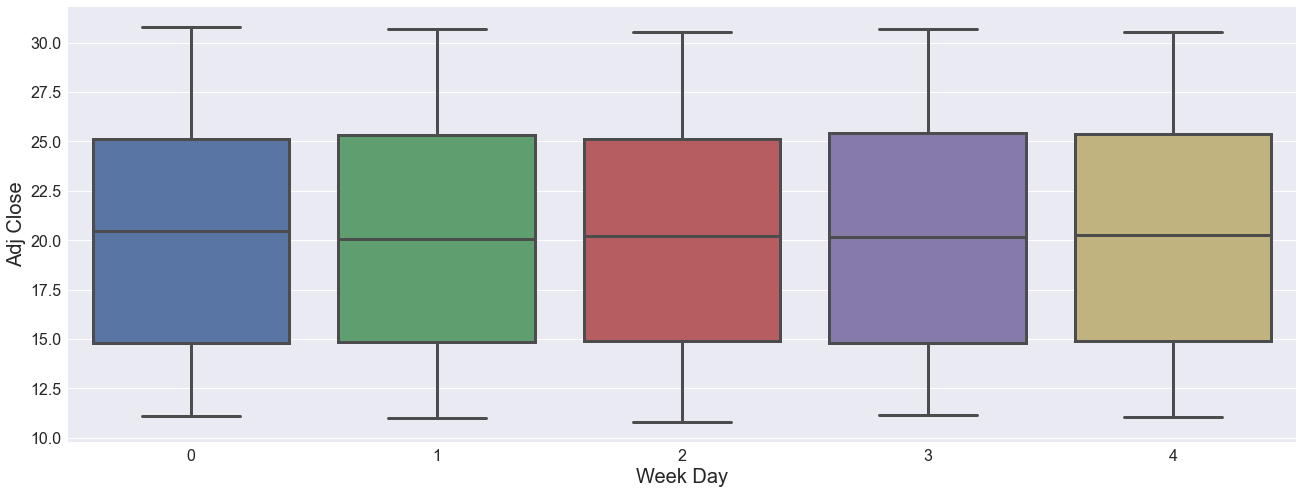

In [13]:
sns.boxplot(petr['Week Day'], petr['Adj Close']);

É comum no mercado de ações as pessoas acreditarem que os preços costumam cair na sexta-feira, devido a um movimento de venda mais expressivo - os especuladores teriam receio de manter os ativos em carteira durante o final de semana - e a aumentar na segunda, pois esses especuladores voltariam a recomprar os ativos. No entanto, o gráfico de caixas (Boxplot) acima mostra que não há diferença expressiva no preço de fechamento ajustado ao longo dos dias da semana, inclusive entre a sextas e a segundas-feiras.

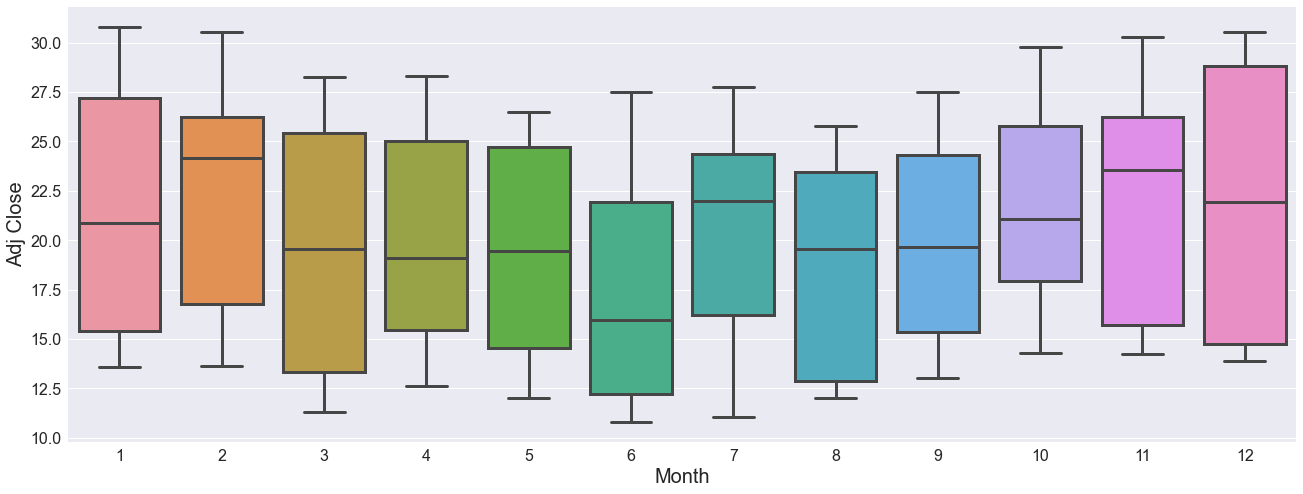

In [14]:
sns.boxplot(petr.Month, petr['Adj Close']);

Porém, pelo menos para os quatro anos contemplados nessa análise, os preços variam ao longo dos meses, indicando que podem haver estratégias mais apropriadas dependendo da época do ano.

# Previsões com ARIMA

O objetivo desta seção é ajustar um modelo estatístico clássico que sirva como baseline para nosso estudo. O modelo selecionado para esse propósito é o SARIMA.

In [15]:
petr1 = petr.copy()

### Análise de estacionariedade

A análise dos gráficos de Autocorrelação e de Autocorrelação Parcial da série temporal pode mostrar propriedades interessantes. Esses gráficos mostram se os valores de uma série temporal estão positiva ou negativamente correlacionados ou, ainda, se são independentes. No caso do preço de fechamento ajustado, o gráfico de autocorrelação (à esquerda) mostra que existe forte correlação positiva entre os valores dessa série temporal até mais para maiores defasagens. Percebe-se que as autocorrelações são significantes até quase 30 defasagens. Tanto o gráfico de autocorrelação como o de autocorrelação parcial podem fornecer informações úteis para a parametrização do modelo ARIMA.

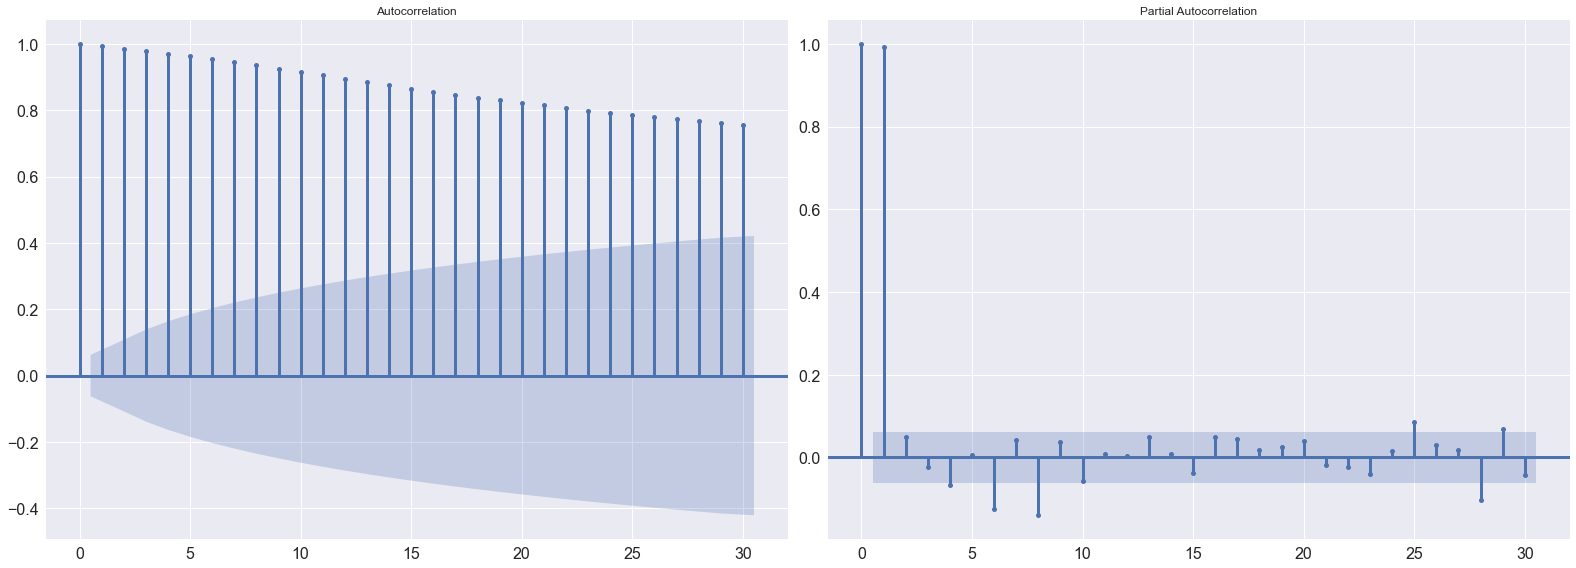

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
smt.graphics.plot_acf(petr1['Adj Close'], ax=ax[0])
smt.graphics.plot_pacf(petr1['Adj Close'], ax=ax[1])
plt.tight_layout()

Nesse caso, o decaimento lento ao longo do eixo x n gráfico de autocorrelação indica que a série é não estacionária, o que também é perceptível por meio de uma análise visual do gráfico da própria série. A não estacionariedade da série pode ser comprovada pelo teste de Dickey-Fuller.

In [17]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(petr1['Adj Close'])[1], 3))

Dickey-Fuller test: p-value = 0.287


Com o p-value alto (acima de 0.05), não é possível rejeitar a hipótese nula de que a série é não estacionária. Se fôssemos utilizar um modelo estatístico mais simples, como o ARMA, teríamos que eliminar essa estacionáriedade antes do ajuste do modelo. Nesse caso, como utilizaremos o modelo ARIMA, isso já é realizado no próprio ajuste do modelo. É possível obter a estacionariedade com a diferenciação da série. Vamos fazer uma diferenciação de ordem 1 para ver se obtemos a estacionariedade.

In [18]:
series_diff = petr1['Adj Close'].diff()[1:]

O gráfico abaixo mostra a série já diferenciada. Apesar de em alguns pontos apresentar uma variância expressiva, ela aparenta ter as propriedades de uma série estacionária.

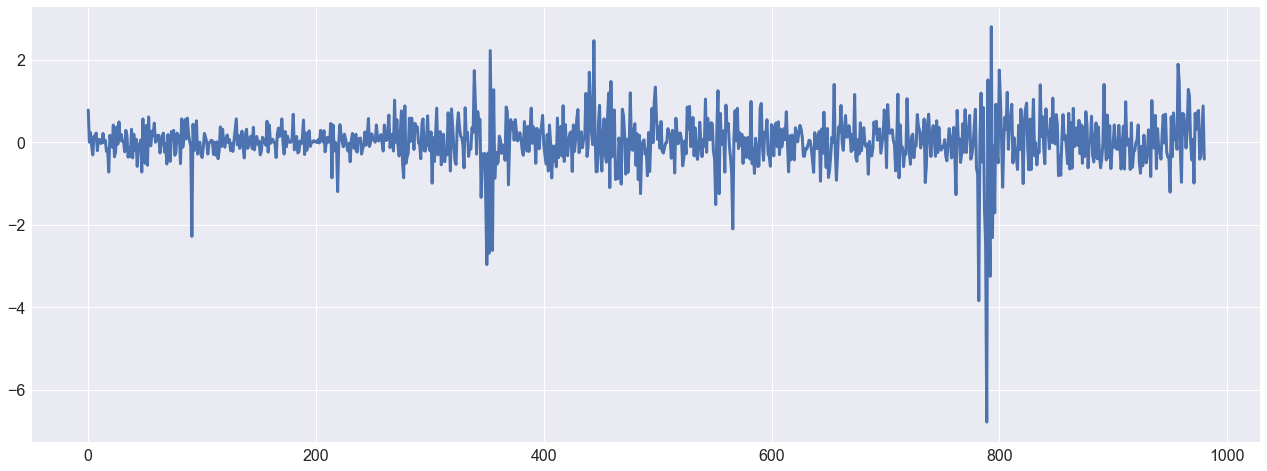

In [19]:
plt.plot(series_diff.values);

Vamos olhar os gráficos de autocorrelação e autocorrelação parcial, abaixo.

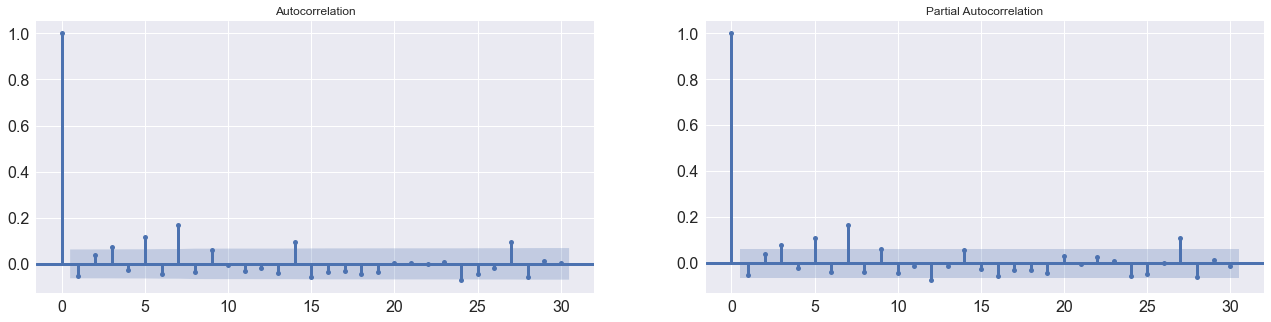

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(22,5))
sm.graphics.tsa.plot_acf(series_diff, ax=ax[0])
sm.graphics.tsa.plot_pacf(series_diff, ax=ax[1]);

Facilmente notamos que os padrões desses gráficos mudaram bastante em relação ao anterior à diferenciação. Esses padrões mostram que a série, após a diferenciação, apresenta propriedades que se assemelham às de uma série estacionária.

No entanto, podemos verificar isso utilizando o teste de Dickey-Fuller sobre a série diferenciada:

In [21]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(series_diff)[1], 3))

Dickey-Fuller test: p-value = 0.0


Agora, com o p-value abaixo de 0.05, podemos rejeitar a hipótese nula de que a série é não estacionária.

### Preprocessamento e Modelagem

Antes de ajustar o modelo ARIMA, precisamos:
1) Preparar os dados, dividindo a série em conjunto de treino e teste; <br>
2) Definir o conjunto de parâmetros p,d,q que será utilizado para ajuste do modelo. Na subseção anterior já descobrimos que com uma diferenciação alcançamos a estacionariedade, ou seja, d é igual a 1.

1) Para divisão da série em dois conjuntos (treino e teste), levaremos em conta que a série possui, no total, 4 anos. Iremos utilizar o último mês para teste e o restante da série para treinamento. Para avaliação do desempenho do modelo iremos utilizar a métrica MAE (Mean Absolute Error).

In [22]:
train_split_date = '2020-11-30'
test_split_date = '2020-12-01'

In [23]:
train = petr1['Adj Close'][:train_split_date]
test = petr1['Adj Close'][test_split_date:]

2) Para definição dos parâmetros p,d, q e P, D, Q foram realizados uma série de teste com diversos arranjos e o arranjo adotado é o que trouxe melhor desempenho.

In [24]:
arima_model = sm.tsa.statespace.SARIMAX(train.values, order=(2,1,2), seasonal_order=(1,1,1,12))
arima_res = arima_model.fit(disp=0)

In [25]:
arima_fitted_values = arima_res.fittedvalues

Abaixo temos uma visualização dos valores de preços de fechamento ajustados (azul) e os valores ajustados pelo modelo (vermelho), somente para o conjunto de treino.

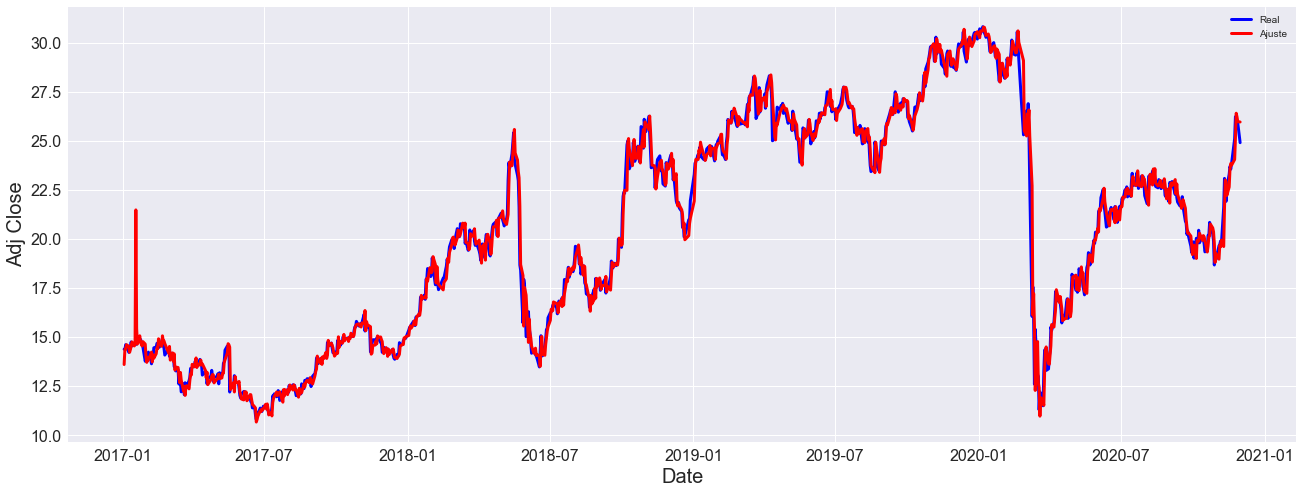

In [26]:
sns.lineplot(train.index[1:], train[1:], color='blue', label='Real')
sns.lineplot(train.index[1:], arima_fitted_values[1:], color='red', label='Ajuste');

Vamos, agora, usar o modelo para fazer previsões sobre o conjunto de teste.

In [27]:
pred_test = arima_res.forecast(steps=len(test))

In [28]:
# Convertendo para Pandas Series
pred_test = pd.Series(pred_test)
pred_test.index = test.index

Abaixo, é possível visualizar os valores do conjunto de teste (azul) e os valores preditos pelo modelo (vermelho). Aparentemente o modelo não apresentou bom desempenho.

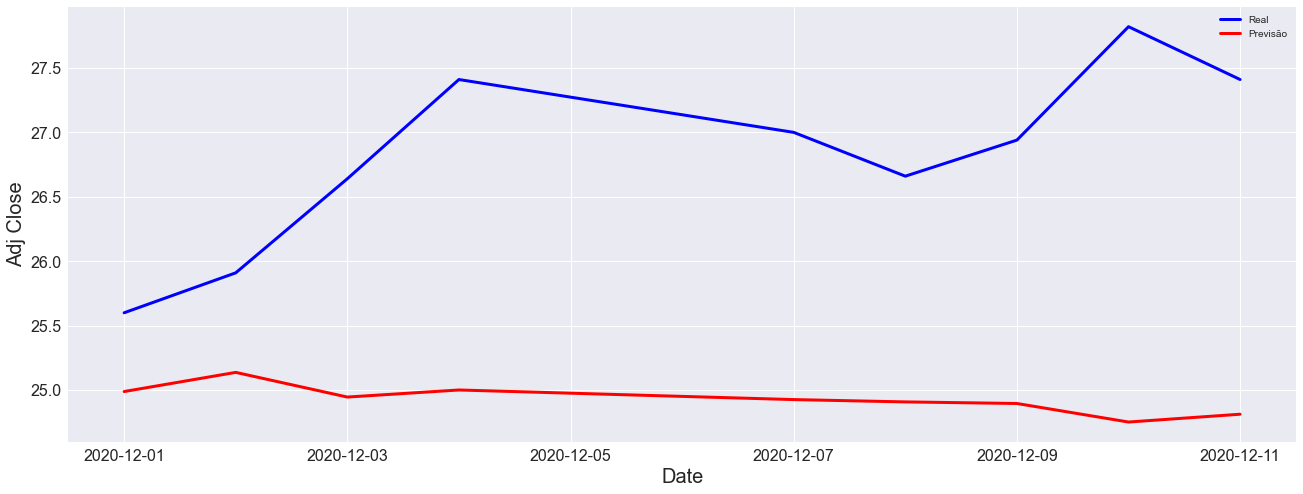

In [29]:
sns.lineplot(test.index, test, color='blue', label='Real')
sns.lineplot(pred_test.index, pred_test, color='red', label='Previsão');

### Métricas

Abaixo, calculamos as métricas MAE (Mean Absolute Error) e MAPE (Mean Absolute Percetage Error) para avaliarmos o desempenho do modelo

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
mae_train = mean_absolute_error(train[1:], arima_fitted_values[1:])
mae_train

0.4037542988601519

In [32]:
mae_test = mean_absolute_error(test[1:], pred_test[1:])
mae_test

2.051096849610914

O MAE mostra que o modelo foi bem no conjunto de treino, apresentando um erro médio de aproximadamente 40 centavos, mas esse erro aumenta bastante no conjunto de teste, indo para um erro médio de aproximadamente 2 reais, o que é um valor bastante considerável. Podemos concluir que o modelo ARIMA não teve bom desempenho. No entanto, esse erro será nosso baseline para compararmos as modelagens com LSTM e com Random Forest.

### Fazendo Previsões para os Próximos 5 dias

In [33]:
predict = arima_res.forecast(steps=5)

In [34]:
predict = pd.Series(predict)
predict.index = pd.bdate_range(start=petr1.index[-1]+timedelta(1), periods=5, freq='B')
predict

2020-12-14    24.988940
2020-12-15    25.137565
2020-12-16    24.946093
2020-12-17    25.000988
2020-12-18    24.926515
Freq: B, dtype: float64

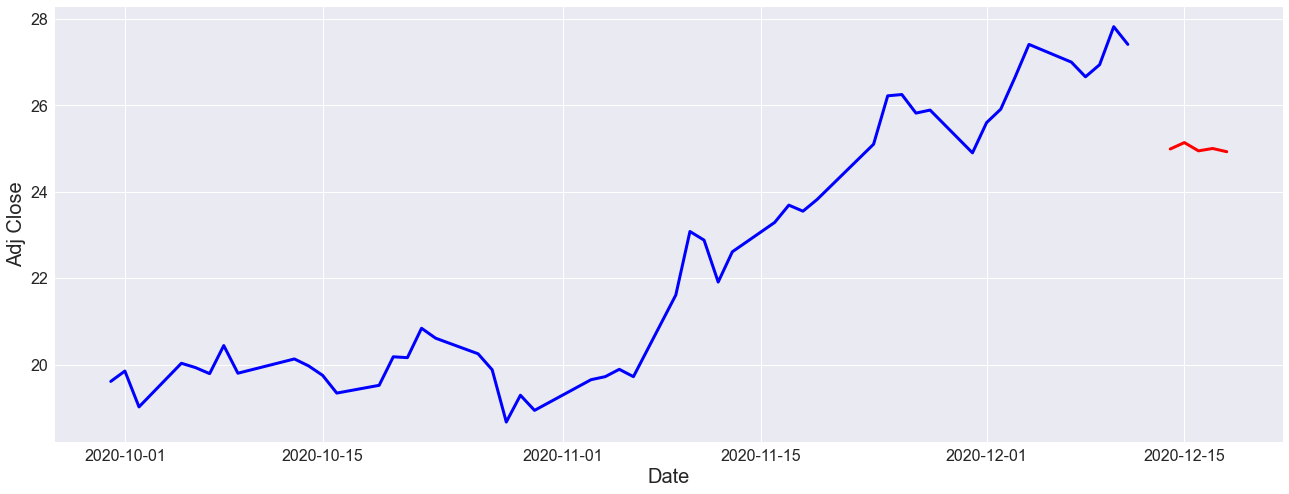

In [35]:
sns.lineplot(petr1['Adj Close'][-50:].index, petr1['Adj Close'][-50:], color='blue')
sns.lineplot(predict.index, predict, color='red');

Definindo o que é tendência de alta, lateral e baixa:
- Se o preço do quinto dia de previsão for 1% mais alto do que o preço de hoje, considera-se que haverá uma tendência de alta para os próximos 5 dias.
- Se o preço do quinto dia de previsão estiver entre 1% mais baixo e 1% mais alto do que o preço de hoje, considera-se que haverá uma tendência lateral.
- Se o preço do quinto dia de previsão estiver 1% mais baixo que o preço de hoje, considera-se que haverá uma tendência de baixa.

In [36]:
def trend_definition(last_x, last_predict):
    if last_predict >= last_x*1.01:
        print('Tendência de Alta para os próximos 5 dias')
    elif (last_predict > last_x*0.99) and (last_predict < last_x*1.01):
        print('Previsão de tendência lateral para os próximos 5 dias')
    else:
        print('Previsão de tendência de baixa para os próximos 5 dias')

In [37]:
trend_definition(petr1['Adj Close'][-1], predict[-1])

Previsão de tendência de baixa para os próximos 5 dias


### Análise Residual

In [38]:
residuals = arima_res.resid

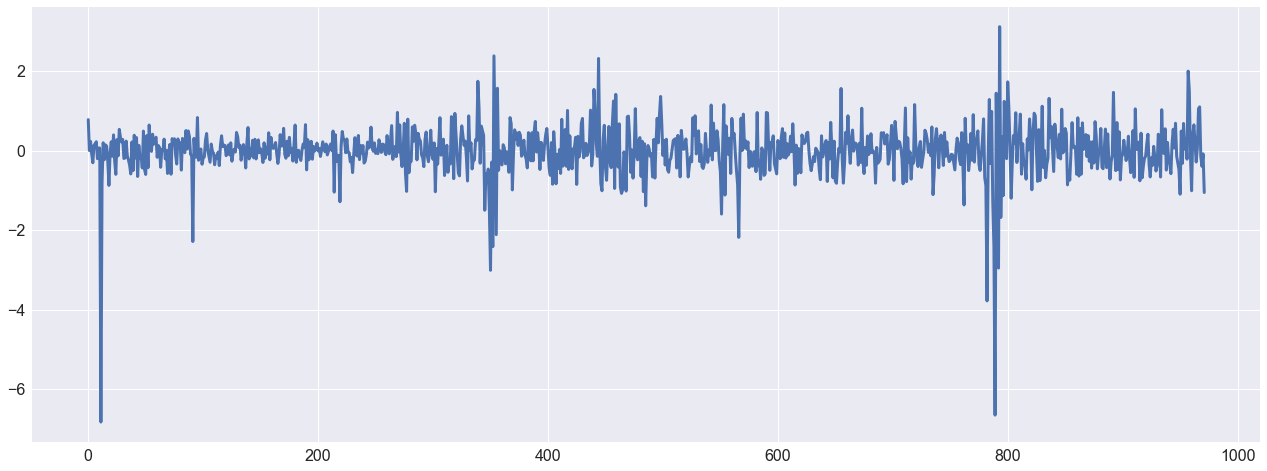

In [39]:
plt.plot(residuals[1:]);

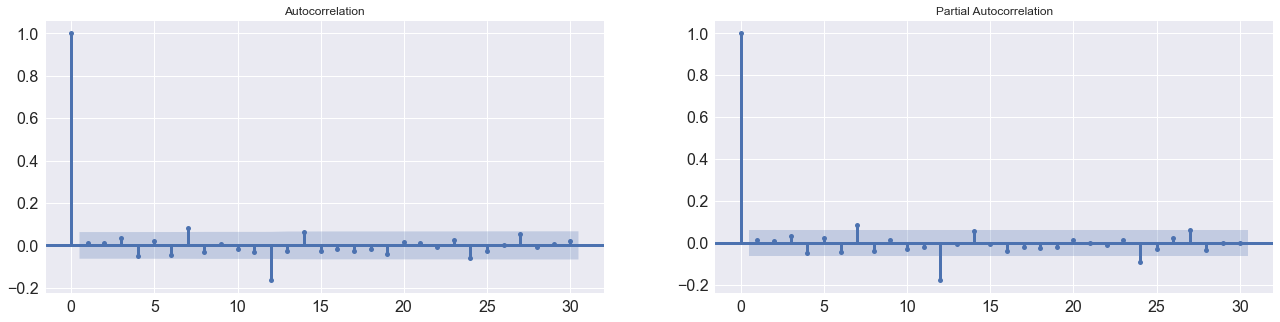

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(22,5))
sm.graphics.tsa.plot_acf(residuals, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals, ax=ax[1]);

In [41]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(residuals)[1], 3))

Dickey-Fuller test: p-value = 0.0


Concluimos que o modelo ARIMA está conseguindo interpretar os dados satisfatoriamente no conjunto de treino mas não está conseguindo prever valores futuros. Inclusive, no conjunto de teste o erro aumentou consideravelmente. Uma das explicações para essa situação é a quarentena que ainda é bastante recente e pode estar impactando as previsões no conjunto de teste e nos 5 dias futuros.

# Previsão da Série Temporal com LSTM


Nessa seção, utilizaremos Deep Learning para prever os valores do ativo no futuro. Utilizaremos duas abordagens:
1) A primeira abordagem consiste em fazer previsões transformando a série temporal em um problema de aprendizado supervisionado (regressão); <br>
2) A segunda abordagem consiste em utilizar o preço de abertura para prever o preço de fechamento ajustado, ambos do mesmo dia. Nesse caso será possível fazer previsões somente para o dia atual.

## Primeira Abordagem: Aprendizado Supervisionado

Nesse caso, para fazermos as predições, utilizaremos uma abordagem que converte a série temporal para um problema de aprendizado supervisionado.

In [42]:
petr2 = petr.copy()

### Preprocessamento dos Dados

Utilizaremos uma função que converterá a série em um problema de aprendizado supervisionado.

In [43]:
def supervised_convert(series, time_steps):
    X = []
    for i in range(len(series) - time_steps):
        X.append(series[i:i + time_steps])

    y = series[time_steps:]
    y = y.reshape(len(y), 1)
    X = np.array(X)

    return X, y

Divisão da série temporal em conjunto de treino e cojunto de teste.

In [44]:
train_split_date = '2020-06-30'
test_split_date = '2020-07-01'

In [45]:
train = petr2['Adj Close'][:train_split_date].values.reshape(len(petr2[:train_split_date]), 1)
test = petr2['Adj Close'][test_split_date:].values.reshape(len(petr2[test_split_date:]), 1)
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (868, 1)
Test shape: (114, 1)


Reescalando os dados entre -1 e 1 para facilitar o aprendizado.

In [46]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

print('Scaled_train shape:', scaled_train.shape)
print('Scaled_test shape:', scaled_test.shape)

Scaled_train shape: (868, 1)
Scaled_test shape: (114, 1)


Aqui é onde convertemos a situação para um problema de aprendizado supervisionado. Nesse caso, os 4 primeiros valores da série serão utilizados para prever o primeiro valor de saída. Então, teremos como entrada uma matriz de comprimento n e largura 4. E o vetor de saída será unidimensional.

In [47]:
time_steps = 4
X_train, y_train = supervised_convert(scaled_train, time_steps)

scaled_test = np.vstack((scaled_train[-time_steps:], scaled_test))
X_test, y_test = supervised_convert(scaled_test, time_steps)

print('X_train and y_train shapes:', X_train.shape, y_train.shape)
print('X_test and y_test shapes:', X_test.shape, y_test.shape)

X_train and y_train shapes: (864, 4, 1) (864, 1)
X_test and y_test shapes: (114, 4, 1) (114, 1)


### Modelagem e Predições

Será utilizada uma rede neural recorrente (LSTM), desenvolvida com a biblioteca Keras. Nesse rede, teremos uma camada LSTM e uma camada de saída densa.

In [48]:
model = Sequential()
model.add(LSTM(30,
        input_shape=(time_steps, 1),
        batch_size=1,
        stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [49]:
model.fit(X_train, y_train,
         epochs=25,
         batch_size=1,
         verbose=0,
         validation_data=(X_test, y_test),
         shuffle=False)

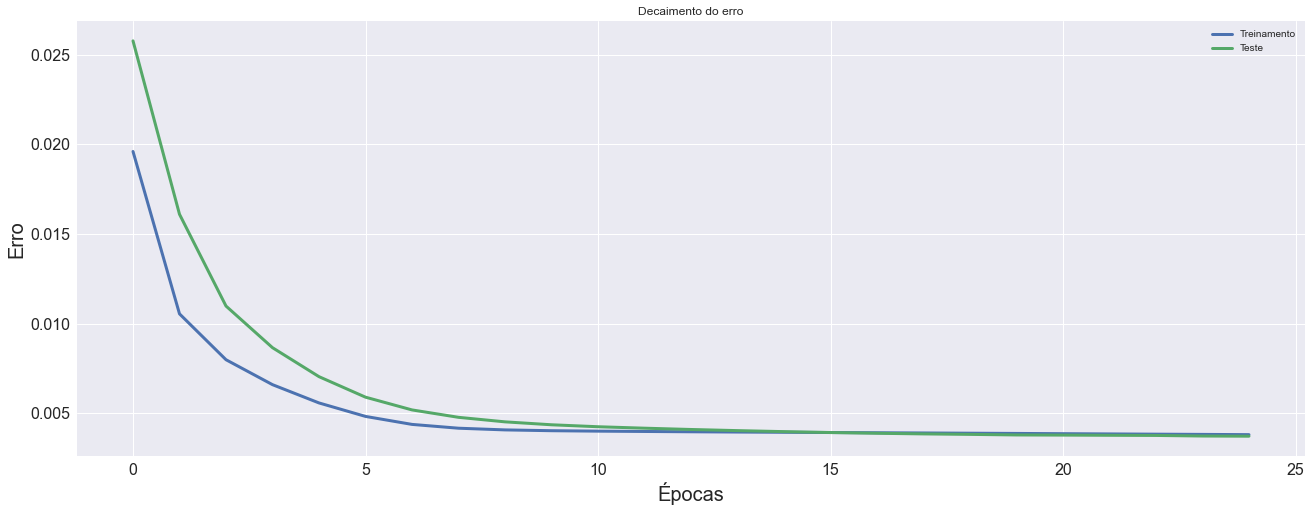

In [50]:
plt.figure(figsize=(22,8))
plt.plot(range(25), model.history.history['loss'], label='Treinamento')
plt.plot(range(25), model.history.history['val_loss'], label='Teste')
plt.title('Decaimento do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.legend();

Aqui fazemos a predição tanto para o conjunto de treino quanto para o conjunto de teste.

In [51]:
predict_train = model.predict(X_train, batch_size=1)

In [52]:
predict_test = model.predict(X_test, batch_size=1)

In [53]:
inverse_predict_train = scaler.inverse_transform(predict_train)
inverse_predict_train = pd.Series(inverse_predict_train.reshape(len(inverse_predict_train),))
inverse_predict_train.index = petr2.index[time_steps:len(X_train)+time_steps]

In [54]:
inverse_predict_test = scaler.inverse_transform(predict_test)
inverse_predict_test = pd.Series(inverse_predict_test.reshape(len(inverse_predict_test),))
inverse_predict_test.index = petr2.index[-len(X_test):]

Visualizando valores reais e predições tanto para o conjunto de treino como para o conjunto de teste. Visualmente podemos dizer que as predições não ficaram tão ruins mas podemos ter uma resposta melhor quanto isso analisando as métricas.

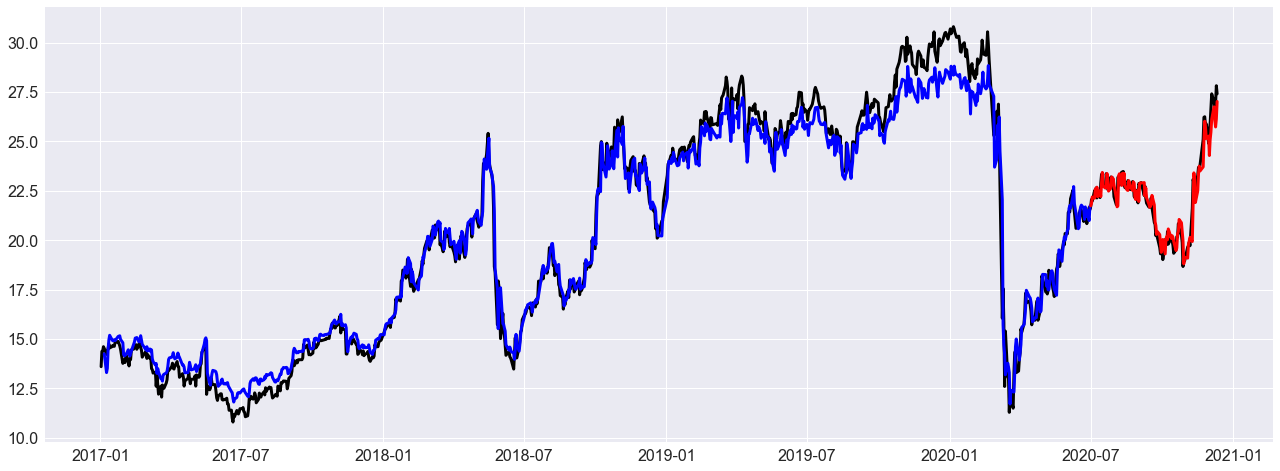

In [55]:
#-> Plotando os resultados com predicted_test
plt.figure(figsize=(22,8))
plt.plot(petr2['Adj Close'], color='black')
plt.plot(inverse_predict_train, color='blue')
plt.plot(inverse_predict_test, color='red');

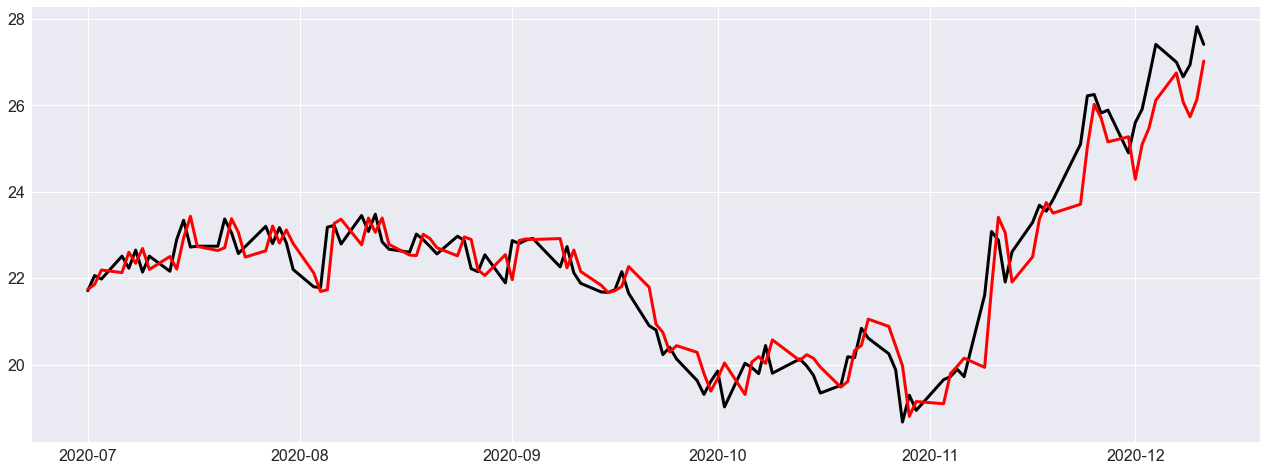

In [57]:
#-> Plotando os resultados com predicted_test
plt.figure(figsize=(22,8))
plt.plot(petr2['Adj Close'][test_split_date:], color='black')
plt.plot(inverse_predict_test, color='red');

### Métricas

O MAE tanto do conjunto de treino quanto do conjunto de teste mostra que as predições estão boas.

In [58]:
mae_train = mean_absolute_error(petr2['Adj Close'][time_steps:][:train_split_date], inverse_predict_train)
mae_train

0.6675621767838796

In [59]:
mae_test = mean_absolute_error(petr2['Adj Close'][test_split_date:], inverse_predict_test)
mae_test

0.47809896971050064

### Previsão para os Próximos 5 Dias

Fazendo previsão para os próximos 5 dias vemos que a tendência é de queda.

In [60]:
five_days_preds = []
first_batch = scaled_test[-time_steps:]
current_batch = first_batch.reshape((1, time_steps, 1))

for i in range(5):
    current_pred = model.predict(current_batch, batch_size=1)[0]
    five_days_preds.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [61]:
five_days_preds = scaler.inverse_transform(np.array(five_days_preds).reshape(len(five_days_preds), 1))
five_days_preds = pd.Series(five_days_preds.ravel())#.ravel()
five_days_preds.index = pd.bdate_range(start=petr2.index[-1]+timedelta(1), periods=5, freq='B')
five_days_preds

2020-12-14    26.359560
2020-12-15    25.297468
2020-12-16    24.408766
2020-12-17    23.693615
2020-12-18    23.157080
Freq: B, dtype: float32

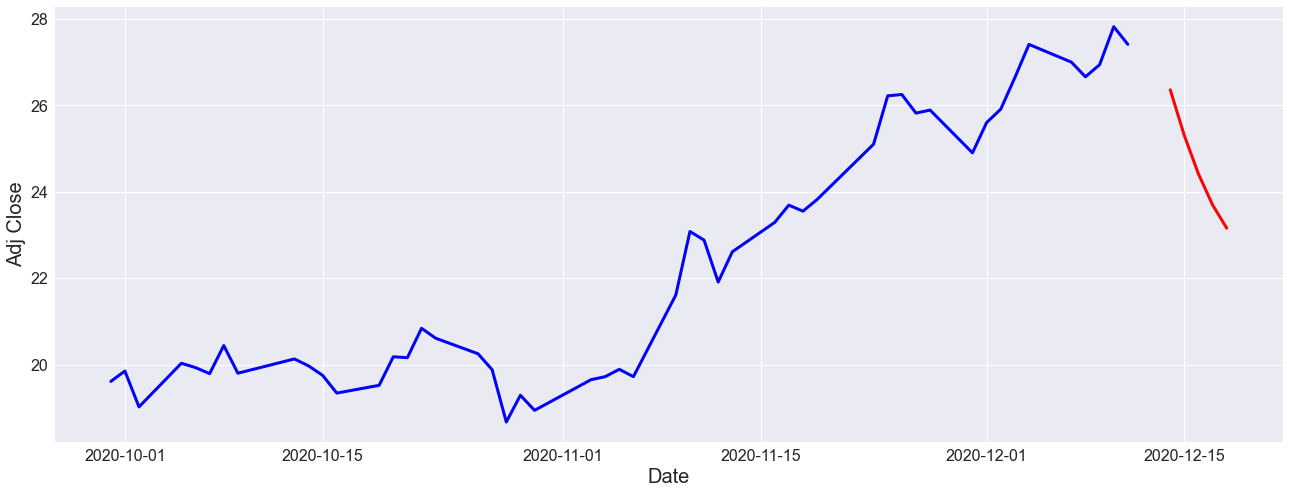

In [62]:
sns.lineplot(petr2['Adj Close'][-50:].index, petr2['Adj Close'][-50:], color='blue')
sns.lineplot(five_days_preds.index, five_days_preds, color='red');

In [63]:
def trend_definition(last_x, last_predict):
    if last_predict >= last_x*1.01:
        print('Tendência de Alta para os próximos 5 dias')
    elif (last_predict > last_x*0.99) and (last_predict < last_x*1.01):
        print('Previsão de tendência lateral para os próximos 5 dias')
    else:
        print('Previsão de tendência de baixa para os próximos 5 dias')

In [64]:
trend_definition(petr2['Adj Close'][-1], predict[-1])

Previsão de tendência de baixa para os próximos 5 dias


### Análise Residual

No entanto, a análise residual diz que a rede não conseguiu extrair todas as informações úteis da série temporal, pois os resíduos não estão formando uma série estacionária e os gráficos de autocorrelação e autocorrelação parcial não estão apresentando o comportamento de uma série estacionária. Isso indica que ajustes devem ser feitos na arquitetura da rede para buscar melhorar seu desempenho.

In [65]:
residuals_lstm = (petr2['Adj Close'][:train_split_date] - inverse_predict_train)[time_steps:]

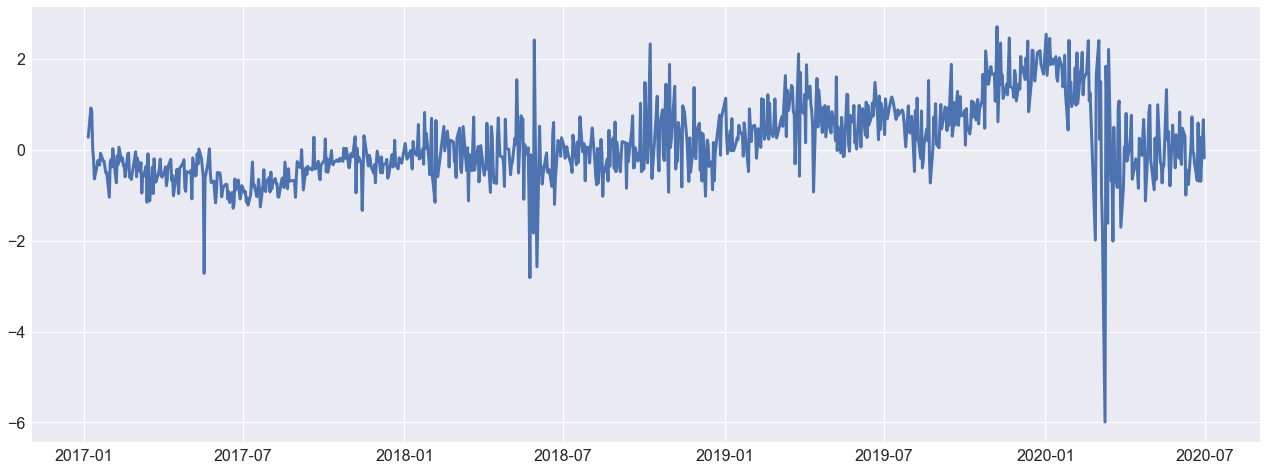

In [66]:
plt.plot(residuals_lstm);

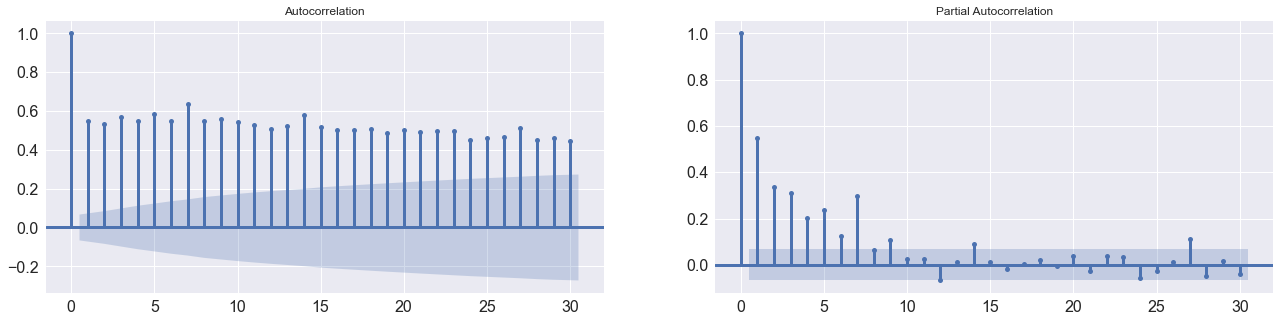

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(22,5))
sm.graphics.tsa.plot_acf(residuals_lstm, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals_lstm, ax=ax[1]);

In [68]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(residuals_lstm)[1], 3))

Dickey-Fuller test: p-value = 0.263


## Segunda Abordagem: Previsões com o Preço de Abertura

Nesse caso, para fazermos as predições, utilizaremos uma abordagem que utiliza o preço de abertura para predizer o preço de fechamento ajustado, ambos do mesmo dia.

In [69]:
petr3 = petr.copy()

### Preprocessamento dos Dados

Então, teremos como vetor de entrada a série com os preços de abertura e como vetor de saída a série com os preços de fechamento ajustados.

In [70]:
X = petr3['Open'].values.reshape(len(petr3), 1)
y = petr3['Adj Close'].values.reshape(len(petr3), 1)
print(X.shape)
print(y.shape)

(982, 1)
(982, 1)


In [71]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_y = scaler.transform(y)
print(scaled_X.shape)
print(scaled_y.shape)

(982, 1)
(982, 1)


In [72]:
X_train = scaled_X[:len(petr3[:train_split_date])]
X_train = X_train.reshape(X_train.shape[0], 1, 1)

y_train = scaled_y[:len(petr3[:train_split_date])]
y_train = y_train.reshape(y_train.shape[0], 1)

print(X_train.shape)
print(y_train.shape)

(868, 1, 1)
(868, 1)


In [73]:
X_test = scaled_X[len(X_train):]
X_test = X_test.reshape(X_test.shape[0], 1, 1)

y_test = scaled_y[len(X_train):]
y_test = y_test.reshape(y_test.shape[0], 1)

print(X_test.shape)
print(y_test.shape)

(114, 1, 1)
(114, 1)


### Modelagem e Predições

Assim como no caso anterior, será utilizada a biblioteca Keras para construção da rede neural recorrente (LSTM). A arquiterura é bastante similar à utilizada anteriormente.

In [74]:
model = Sequential()
model.add(LSTM(30,
    input_shape=(1, 1),
    batch_size=1,
    stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [75]:
model.fit(X_train, y_train,
         batch_size=1,
         epochs=25,
         verbose=0,
         validation_data=(X_test, y_test),
         shuffle=False)

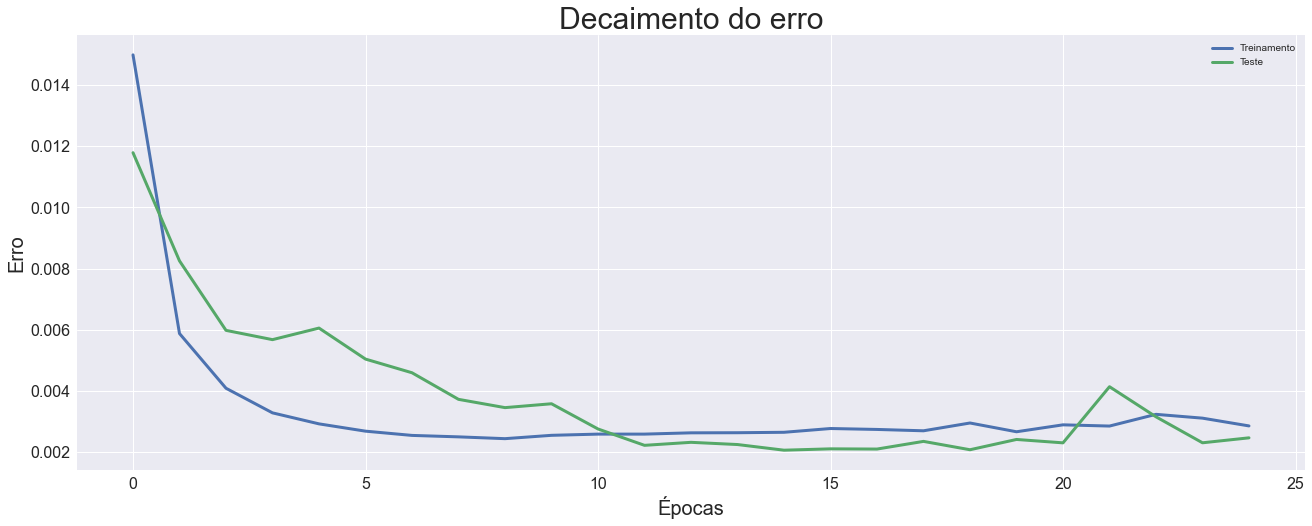

In [76]:
fig = plt.figure(figsize=(22,8))
plt.plot(range(25), model.history.history['loss'], label='Treinamento')
plt.plot(range(25), model.history.history['val_loss'], label='Teste')
plt.title('Decaimento do erro', fontsize=30)
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.legend();

In [77]:
predict_train = model.predict(X_train, batch_size=1)

In [78]:
predict_test = model.predict(X_test, batch_size=1)

In [79]:
inverse_predict_train = scaler.inverse_transform(predict_train)
inverse_predict_train = pd.Series(inverse_predict_train.reshape(len(inverse_predict_train),))
inverse_predict_train.index = petr3.index[:len(X_train)]

In [80]:
inverse_predict_test = scaler.inverse_transform(predict_test)
inverse_predict_test = pd.Series(inverse_predict_test.reshape(len(inverse_predict_test),))
inverse_predict_test.index = petr3.index[-len(X_test):]

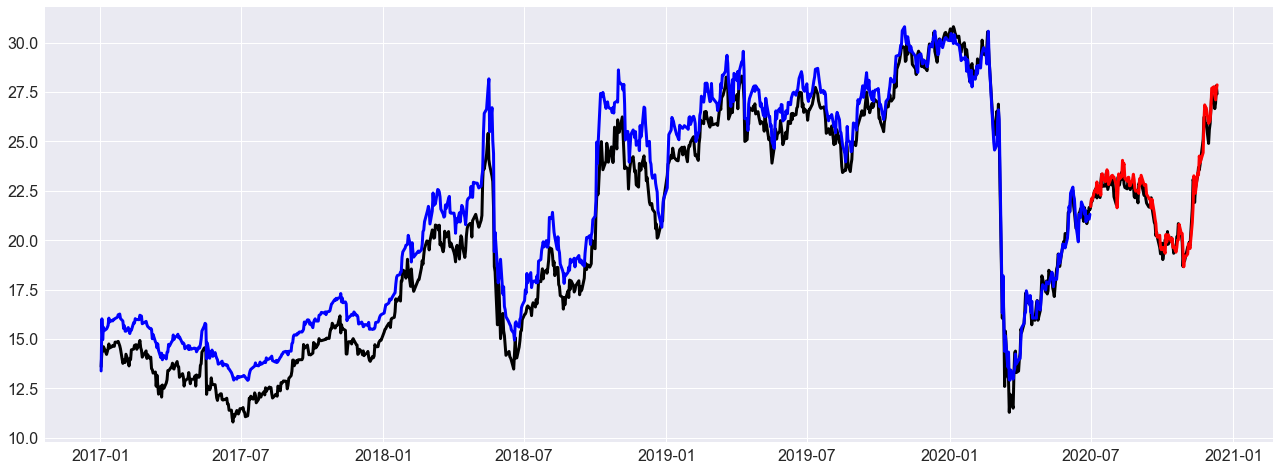

In [81]:
#-> Plotando os resultados com predicted_test
plt.figure(figsize=(22,8))
plt.plot(petr3['Adj Close'], color='black')
plt.plot(inverse_predict_train, color='blue')
plt.plot(inverse_predict_test, color='red');

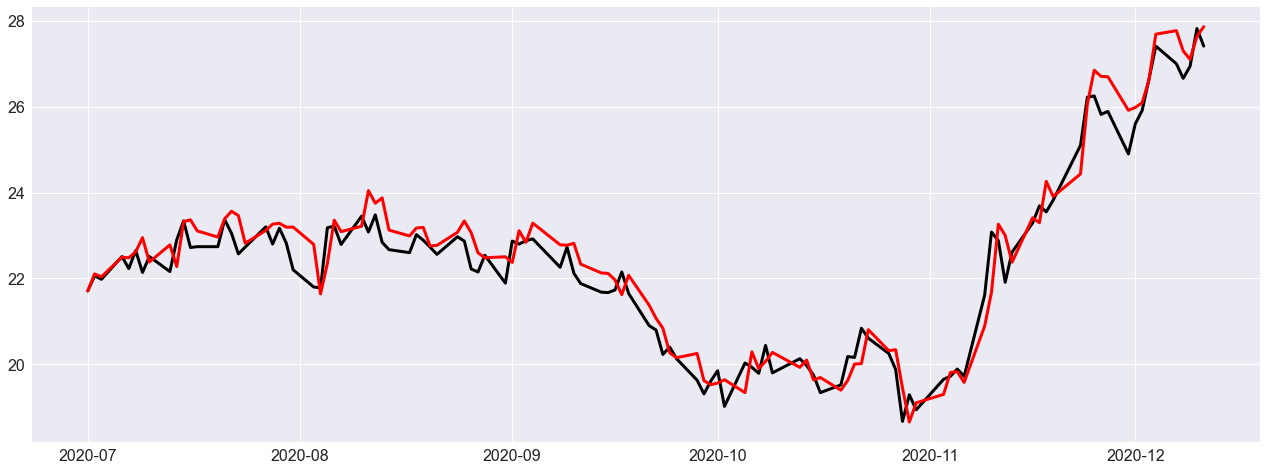

In [82]:
#-> Plotando os resultados com predicted_test
plt.figure(figsize=(22,8))
plt.plot(petr3['Adj Close'][test_split_date:], color='black')
plt.plot(inverse_predict_test, color='red');

### Métricas

O erro na amostra é considerável. No entanto, de forma surpreendente, ele é bem menor fora da amostra.

In [83]:
mae_train = mean_absolute_error(petr3['Adj Close'][:train_split_date], inverse_predict_train)
mae_train

1.1921749653354767

In [84]:
mae_test = mean_absolute_error(petr3['Adj Close'][test_split_date:], inverse_predict_test)
mae_test

0.39086649710671945

### Análise Residual

Mais uma vez, a análise residual mostra que a rede neural não teve bom desempenho em captar as informações da série temporal, pois a série residual é não estacionária. Da mesma forma, os gráficos de autocorrelação e autocorrelação parcial não apresentam comportamento de uma série estacionária. Isso indica que ajustes devem ser feitos na arquitetura da rede para buscar melhorar seu desempenho.

In [85]:
residuals_lstm_2 = petr3['Adj Close'][:train_split_date] - inverse_predict_train

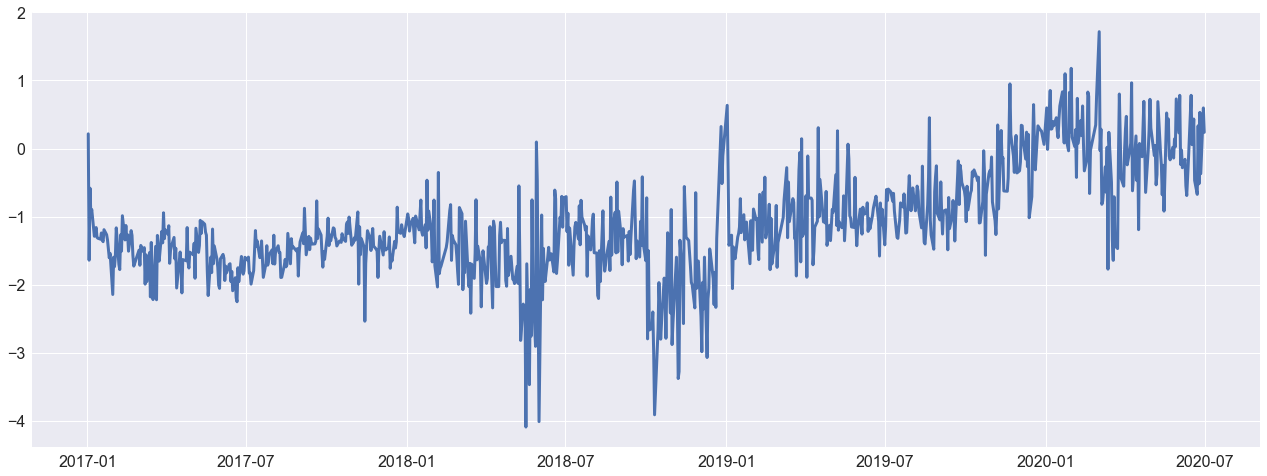

In [86]:
plt.plot(residuals_lstm_2);

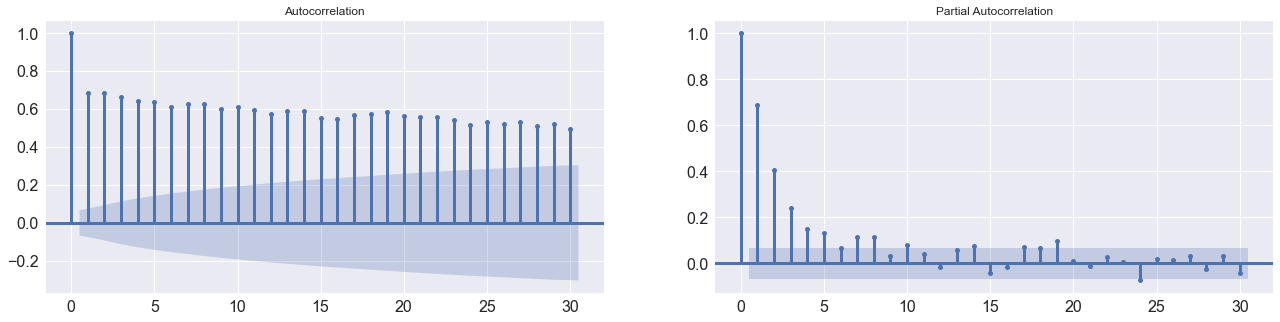

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(22,5))
sm.graphics.tsa.plot_acf(residuals_lstm_2, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals_lstm_2, ax=ax[1]);

In [88]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(residuals_lstm_2)[1], 3))

Dickey-Fuller test: p-value = 0.614


# Previsão com Random Forest

O objetivo dessa seção é modelar a série com um ensemble de machine learning e comparar com as modelagens realizadas anteriormente.

In [89]:
petr5 = petr.copy()

Vamos iniciar criando algumas variáveis a mais para o conjunto de dados ficar mais robusto. Isso pode ajudar o algoritmo a encontrar padrões que melhorarão as previsões. Criamos, então, duas variáveis novas: semana do ano e dia do ano. Lembrando que anteriormente já havíamos criado outras variáveis: mês, dia do mês, ano, e dia da semana.

In [90]:
petr5['Week Year'] = petr5.index.weekofyear
petr5['Day Year'] = petr5.index.dayofyear

In [91]:
petr5.head()

,Open,High,Low,Close,Adj Close,Volume,Month,Week Day,Day,Year,Week Year,Day Year
Date,,,,,,,,,,,,
2017-01-02,14.64,14.70,14.60,14.66,13.600121,7525700,1,0,2,2017,1,2
2017-01-03,14.95,15.65,14.95,15.50,14.379391,39947800,1,1,3,2017,1,3
2017-01-04,15.45,15.68,15.31,15.50,14.379391,37071700,1,2,4,2017,1,4
2017-01-05,15.70,15.91,15.62,15.75,14.611317,47586300,1,3,5,2017,1,5
2017-01-06,15.78,15.92,15.50,15.66,14.527822,25592000,1,4,6,2017,1,6


In [92]:
train_split_date = '2020-06-30'
test_split_date = '2020-07-01'

In [93]:
X_train = petr5[:train_split_date].reset_index(drop=True)
X_test = petr5[test_split_date:].reset_index(drop=True)
print(X_train.shape)
print(X_test.shape)

(868, 12)
(114, 12)


Desejamos que o modelo preveja o valor do fechamento ajustado para o próximo dia. Para isso, o vetor y de saída será o preço de fechameto ajustado com um shift de -1 para trazer para hoje o preço de amanhã. Com esse shift de -1, o último valor, tanto de y_train como de y_test, ficam com NaN. Preenchemos o NaN do y_train com o último primeiro valor de X_test. Com relação ao y_test, o último valor é NaN. Nesse caso, a última predição feita com os últimos valores válidos do y_test.

In [94]:
y_train = np.concatenate((petr5['Adj Close'][:train_split_date].shift(-1).values[:-1], np.array([X_test['Adj Close'][0]])))
y_test = petr5['Adj Close'][test_split_date:].shift(-1).values
print(y_train.shape)
print(y_test.shape)

(868,)
(114,)


In [95]:
model = RandomForestRegressor(n_jobs=-1, random_state=0, min_samples_leaf=2, n_estimators=500)
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=500, n_jobs=-1,
                      random_state=0)

In [96]:
predict = model.predict(X_test)
predict.shape

(114,)

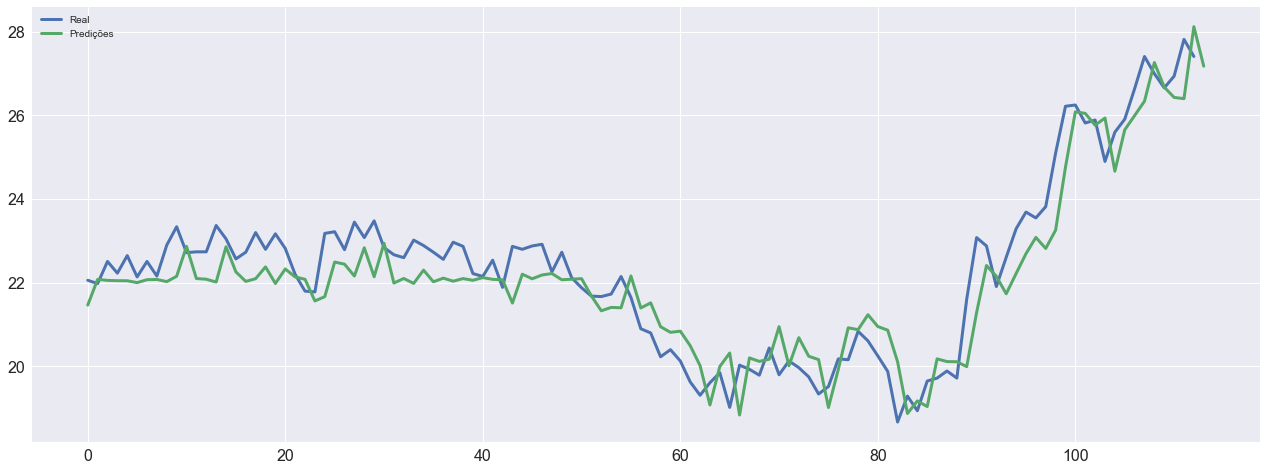

In [97]:
sns.lineplot(range(114), y_test, label='Real')
sns.lineplot(range(114), predict, label='Predições');

O MAE mostra que o Random Forest em média errou a previsão em 61 centavos.

In [98]:
mae = mean_absolute_error(y_test[:-1], predict[:-1])
mae

0.6159128336050882

Previsão para o próximo dia:

In [99]:
predict[-1]

27.177035990266962

# Análise de Cointegração com Outros Ativos

Nesse estratégia, faz-se uma busca entre diversos ativos procurando pares de ativos que possuam alta cointegração. Com esses pares é possível desenvolver a estratégia conhecida como "Long & Short". Nessa seção, apresentamos alguns exemplos. No entanto, infelizmente, nesses exemplos as séries não apresentam as características necessárias para implementação dessa estratégia. No entanto, mesmo assim, é possível ter uma ideia de como a estratégia funciona.

In [100]:
petr4 = petr.copy()

### Petrobrás e Vale

Vamos olhar o par PETR4 e VALE3.

In [101]:
vale = yf.download("VALE3.SA", start="2017-01-01", end="{}".format(today))

[*********************100%***********************]  1 of 1 completed


In [102]:
petr4 = petr4['Adj Close'].values
vale = vale['Adj Close'].values

Olhando o gráfico das duas séries, parece que há uma certa correlação entre eles.

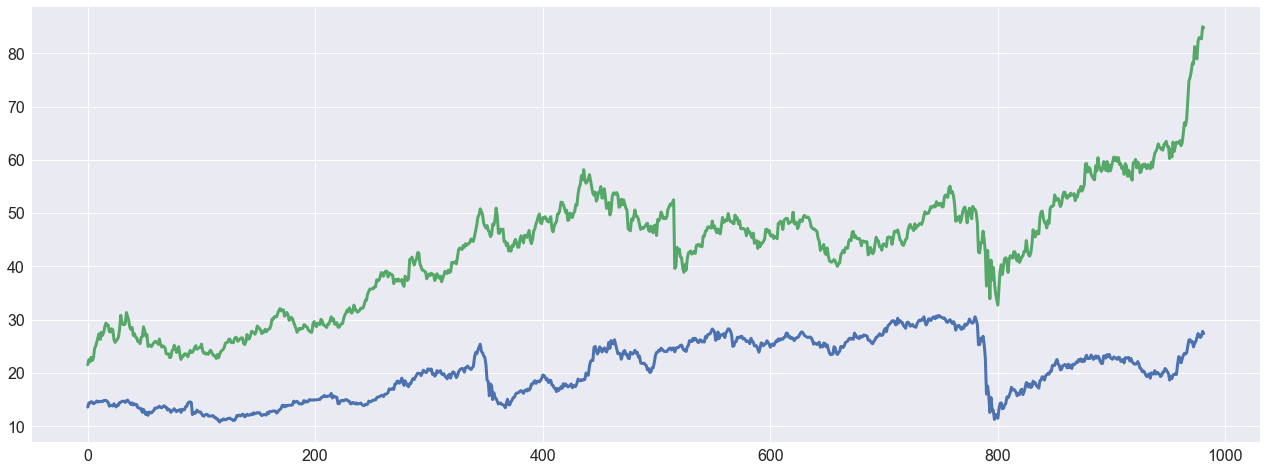

In [103]:
sns.lineplot(range(len(petr4)), petr4)
sns.lineplot(range(len(vale)), vale);

O gráfico abaixo da regressão linear entre as duas séries mostra que a correlação entre os ativos não aparenta ser muito forte. Para comprovar se há correlação e se essa correlação não é espúria, vamos fazer um teste de cointegração.

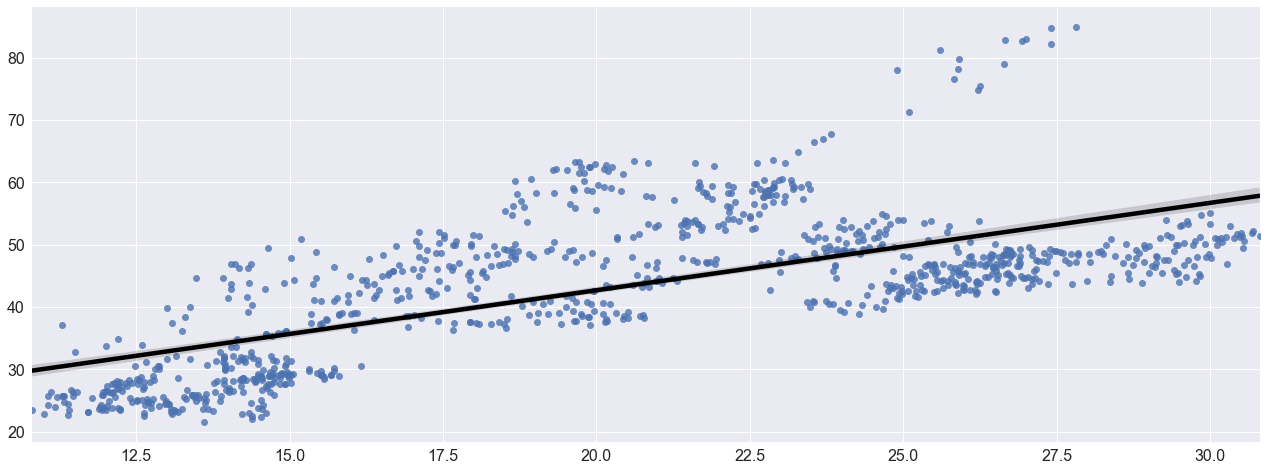

In [104]:
sns.regplot(petr4, vale, line_kws={"color": "black"});

In [105]:
coint_test = ts.coint(petr4, vale)
print('Teste de cointegração: p-value = {}'.format(coint_test[1]))

Teste de cointegração: p-value = 0.4236550680885676


O p-value do teste de cointegração mostra que não podemos rejeitar a hipótese nula de qua não há cointegração entre esses dois ativos. Portanto, não é possível desenvolver a estratégia de Long & Short com eles. Além disso, para que a estratégia possa ser aplicada, o resíduo deve ser uma série estacionária. Temos abaixo uma análise mostrando que isso não acontece nesse caso.

In [106]:
model_1 = LinearRegression()
model_1.fit(petr4.reshape(-1, 1), vale.reshape(-1, 1))
pred_1 = model_1.predict(petr4.reshape(-1, 1))
resid_1 = vale - pred_1.ravel()

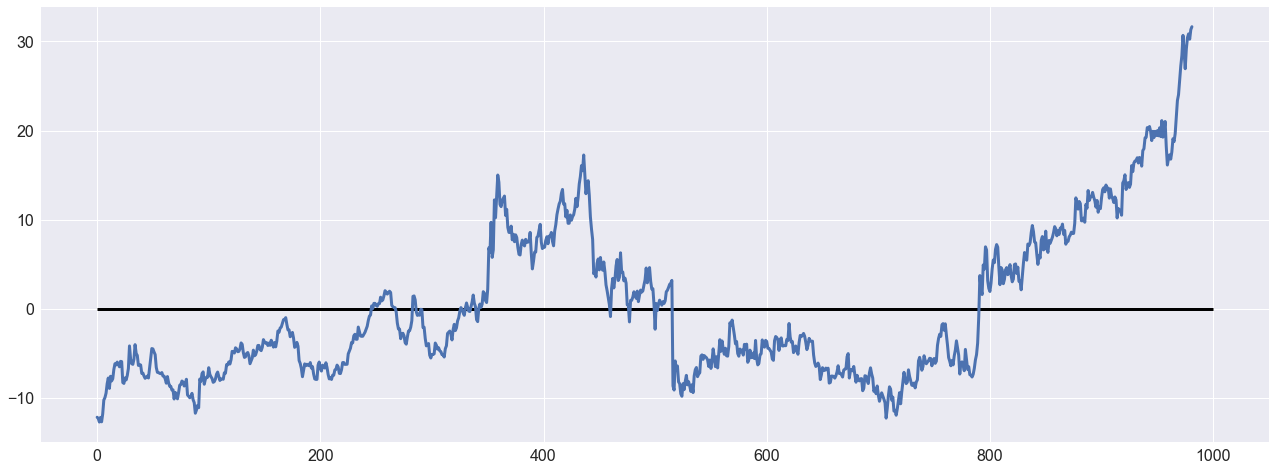

In [107]:
sns.lineplot(range(len(resid_1)), resid_1)
plt.hlines(y=0, xmin=0, xmax=1000, color='black');

In [108]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(resid_1)[1], 3))

Dickey-Fuller test: p-value = 0.938


### Bradesco e Itaú

Nesse caso, vamos testar um par com duas ações do setor bancário: BBDC4 e ITUB4.

In [131]:
bbdc = yf.download("BBDC4.SA", start="2018-01-01", end="{}".format(today))
itub = yf.download("ITUB4.SA", start="2018-01-01", end="{}".format(today))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [110]:
bbdc = bbdc['Adj Close'].dropna().values
itub = itub['Adj Close'].values

Os gráficos dos dois ativos mostram que as séries parecem ser bastante correlacionadas.

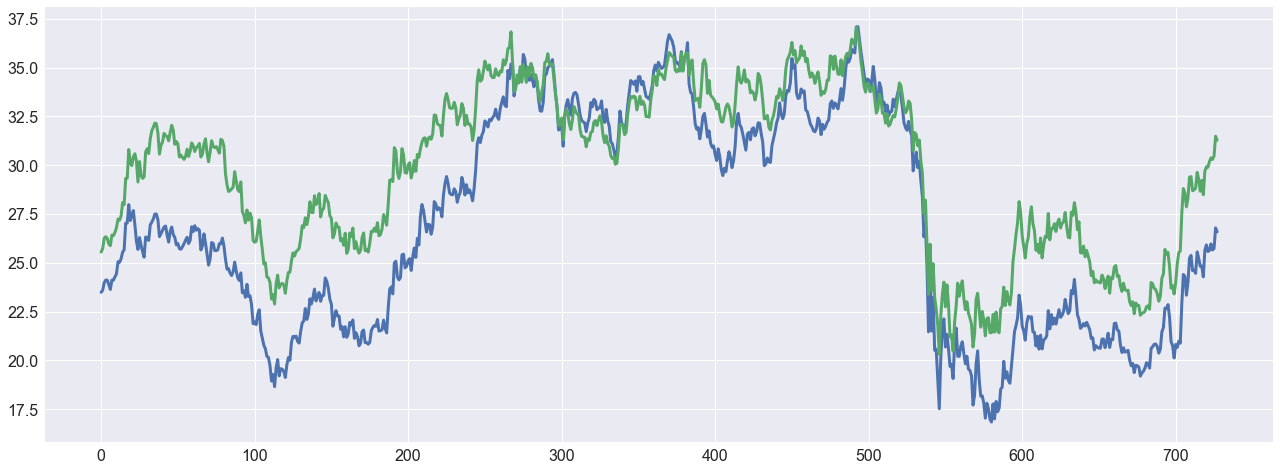

In [111]:
sns.lineplot(range(len(bbdc)), bbdc)
sns.lineplot(range(len(itub)), itub);

O mesmo é mostrado quando plotamos as duas séries com uma reta de regressão linear.

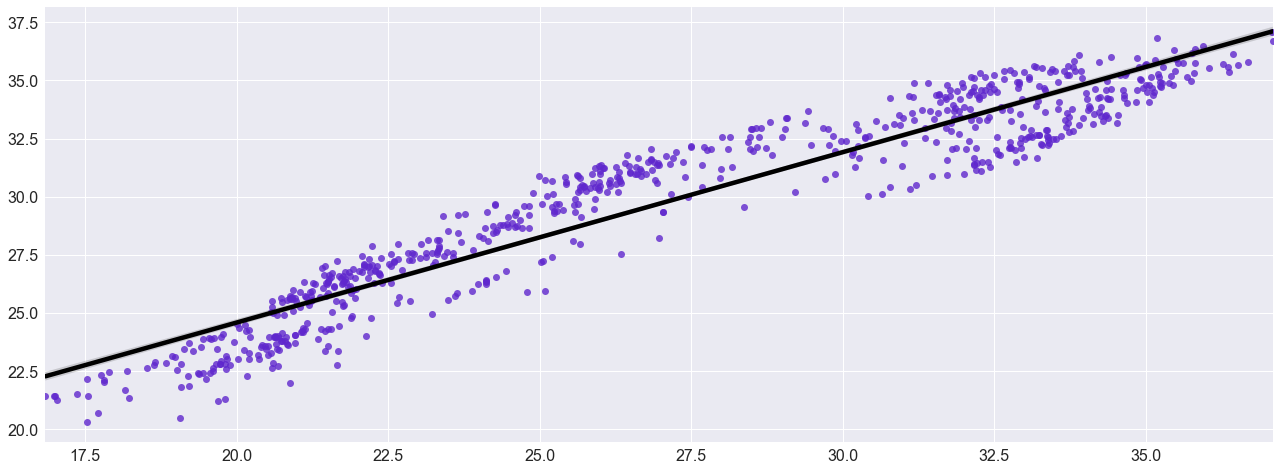

In [112]:
sns.regplot(bbdc, itub, color='#5f27cd', line_kws={"color": "black"});

No entanto, o teste de cointegração mostra que não há cointegração entre esses dois ativos.

In [113]:
coint_test = ts.coint(bbdc, itub)
print('Teste de cointegração: p-value = {}'.format(coint_test[1]))

Teste de cointegração: p-value = 0.4974937205793429


A análise de resíduos mostra que a série residual não é estacionária, confirmando que a estratégia de Long&Short não poderá ser utilizada com esse par de ativos.

In [114]:
model_2 = LinearRegression()
model_2.fit(bbdc.reshape(-1, 1), itub.reshape(-1, 1))
pred_2 = model_2.predict(bbdc.reshape(-1, 1))
resid_2 = itub - pred_2.ravel()

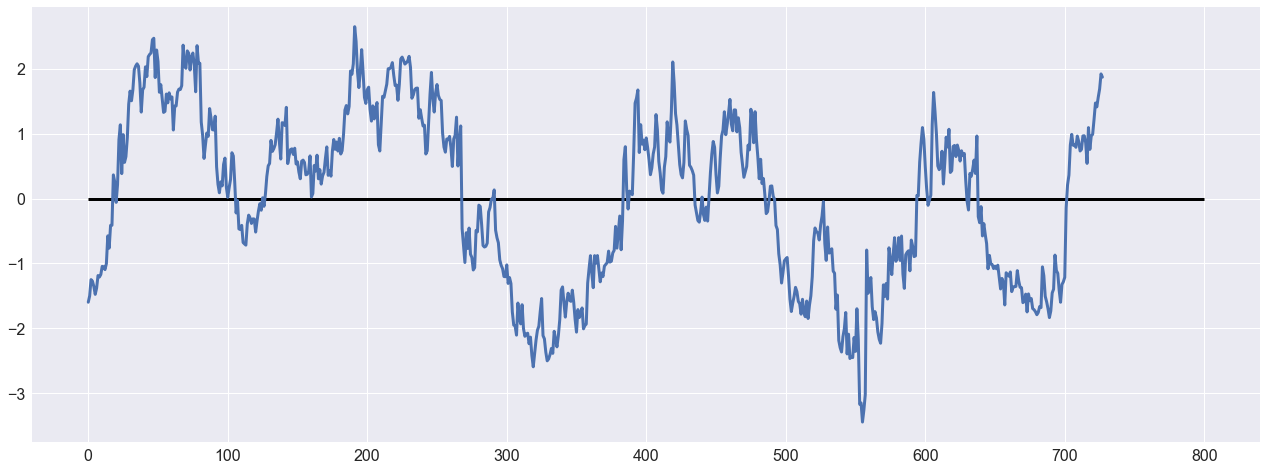

In [115]:
sns.lineplot(range(len(resid_2)), resid_2)
plt.hlines(y=0, xmin=0, xmax=800, color='black');

In [116]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(resid_2)[1], 3))

Dickey-Fuller test: p-value = 0.105


### Petrobrás e Chevron

In [117]:
chevron = yf.download("CHVX34.SA", start="2017-01-01", end="{}".format(today))

[*********************100%***********************]  1 of 1 completed


In [118]:
chevron = chevron['Adj Close'].values

Abaixo vemos os gráficos de preços dos dois ativos. Os valores foram normalizados devido a uma diferença grande na escala de preços entre eles.

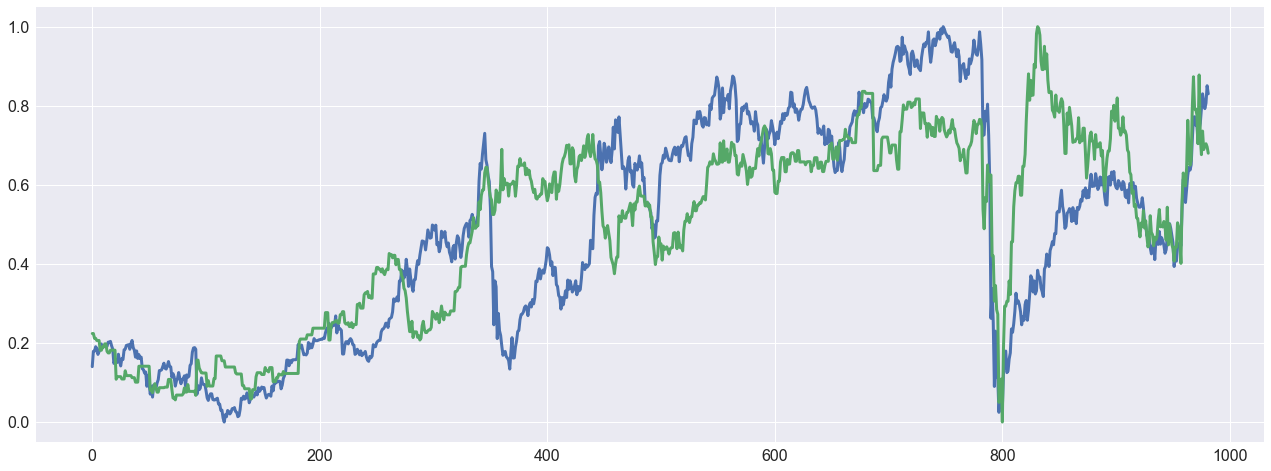

In [119]:
sns.lineplot(range(len(petr4)), ((petr4 - np.min(petr4)) / (np.max(petr4)-np.min(petr4))) )
sns.lineplot(range(len(chevron)), ((chevron-np.min(chevron)) / (np.max(chevron)-np.min(chevron))) );

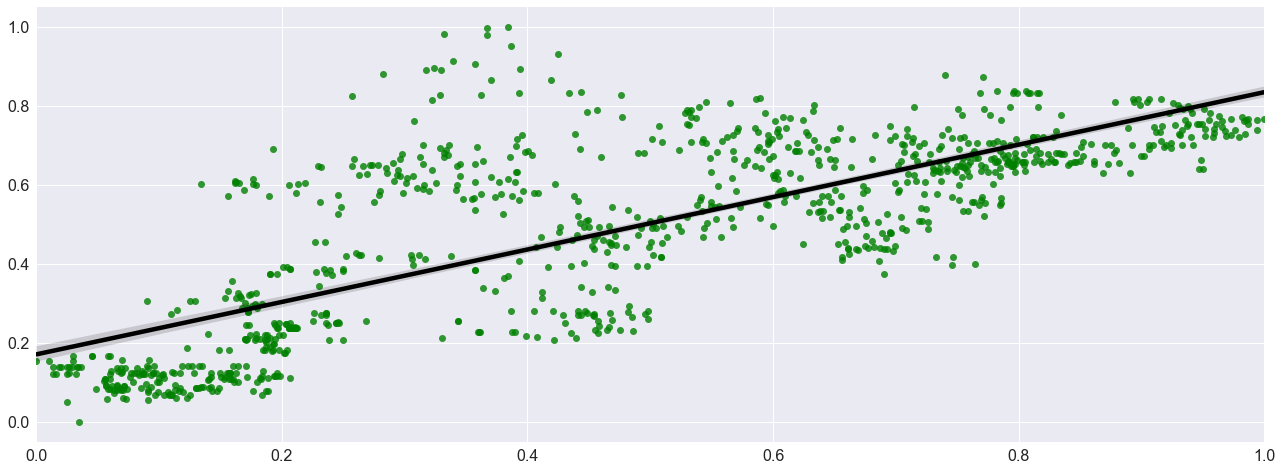

In [121]:
sns.regplot(((petr4 - np.min(petr4)) / (np.max(petr4)-np.min(petr4))), ((chevron-np.min(chevron)) / (np.max(chevron)-np.min(chevron))), color='g', line_kws={"color": "black"});

O teste de cointegração mostra que não podemos dizer que as séries são cointegradas.

In [122]:
coint_test = ts.coint(((petr4 - np.min(petr4)) / (np.max(petr4)-np.min(petr4))), ((chevron-np.min(chevron)) / (np.max(chevron)-np.min(chevron))))
print('Teste de cointegração: p-value = {}'.format(coint_test[1]))

Teste de cointegração: p-value = 0.1033085322761329


No entanto, a análise de resíduos mostra que a série residual da regressão linear é estacionária. Talvez essas duas séries já estiveram cointegradas e perderam a cointegração, talvez momentaneamente.

In [123]:
model_3 = LinearRegression()
model_3.fit(((petr4 - np.min(petr4)) / (np.max(petr4)-np.min(petr4))).reshape(-1, 1), ((chevron-np.min(chevron)) / (np.max(chevron)-np.min(chevron))).reshape(-1, 1))
pred_3 = model_3.predict(((petr4 - np.min(petr4)) / (np.max(petr4)-np.min(petr4))).reshape(-1, 1))
resid_3 = ((chevron-np.min(chevron)) / (np.max(chevron)-np.min(chevron))) - pred_3.ravel()

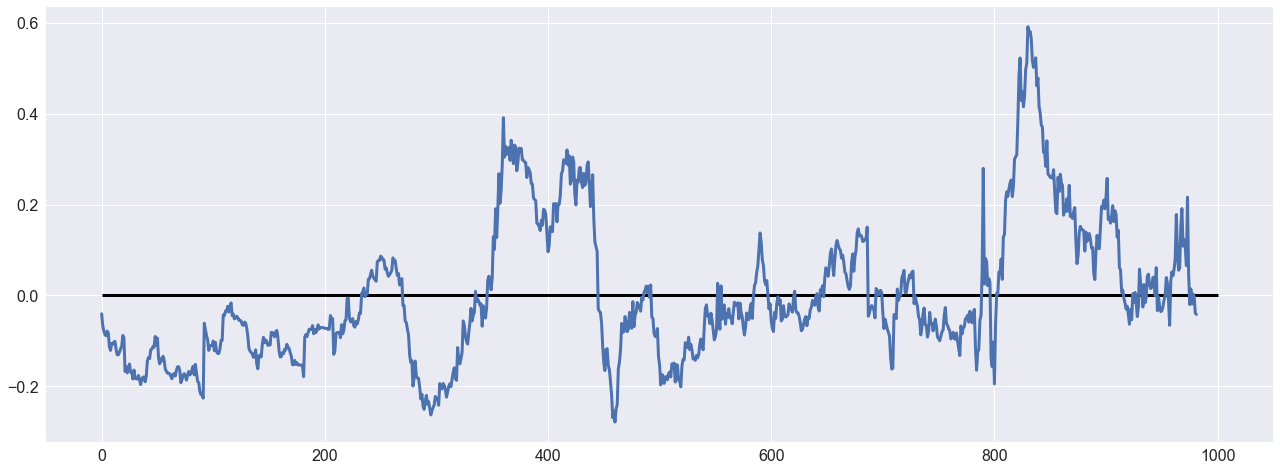

In [124]:
sns.lineplot(range(len(resid_3)), resid_3)
plt.hlines(y=0, xmin=0, xmax=1000, color='black');

In [125]:
print('Dickey-Fuller test: p-value =', round(sm.tsa.stattools.adfuller(resid_3)[1], 3))

Dickey-Fuller test: p-value = 0.023
